Top强震验证：
        mag  longitude  latitude
37371  8.2   -70.7691  -19.6097
50562  7.9   178.7352   51.8486


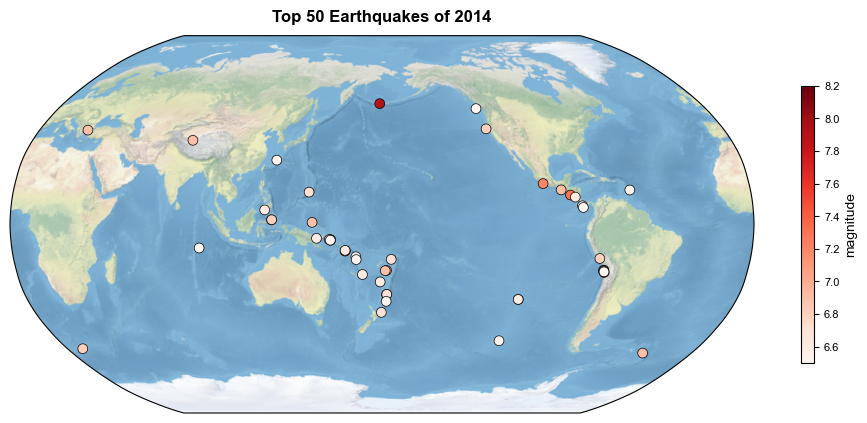

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
def main():
    # 1. 读取数据并严格清洗
    df = pd.read_csv('usgs_earthquakes.csv')
    # 2. 处理时间列（精确筛选2014年1月1日至12月31日的数据）
    df['time'] = pd.to_datetime(df['time'], errors='coerce')  # 强制转换，错误值设为NaT
    # 筛选2014年全年（UTC时间）
    start = pd.to_datetime('2014-01-01 00:00:00')
    end = pd.to_datetime('2014-12-31 23:59:59')
    df_2014 = df[(df['time'] >= start) & (df['time'] <= end)]
    
    # 3. 清洗震级和坐标数据
    df_2014 = df_2014[
        (pd.to_numeric(df_2014['mag'], errors='coerce').notna()) & 
        (df_2014['mag'] >= 6.5) &                                   
        (pd.to_numeric(df_2014['longitude'], errors='coerce').between(-180, 180)) & 
        (pd.to_numeric(df_2014['latitude'], errors='coerce').between(-90, 90))      
    ].copy()
    
    # 4. 转换震级列为数值型
    df_2014['mag'] = pd.to_numeric(df_2014['mag'])
    
    # 5. 筛选2014年震级Top50，按震级降序，若震级相同则按时间排序
    top50_2014 = df_2014.sort_values(
        by=['mag', 'time'],  # 震级优先，相同震级按时间早到晚排序
        ascending=[False, True]
    ).head(50)
    
    # 打印Top50中震级≥7.8的点（2014年已知强震）
    print("Top强震验证：\n", top50_2014[top50_2014['mag'] >= 7.8][['mag', 'longitude', 'latitude']])
    # 6. 绘制地图
    fig = plt.figure(figsize=(12, 6))
    proj = ccrs.Robinson(central_longitude=180)
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_global()
    ax.stock_img() 
    
    # 7. 绘制地震点
    scatter = ax.scatter(
        x=top50_2014['longitude'],
        y=top50_2014['latitude'],
        c=top50_2014['mag'],
        cmap='Reds',  
        transform=ccrs.PlateCarree(),
        edgecolors='black',
        linewidth=0.5,
        s=50  
    )
    
    # 8. 调整颜色条
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.6)
    cbar.set_label('magnitude', fontsize=10)
    cbar.set_ticks(np.arange(6.6, 8.3, 0.2))  
    cbar.ax.tick_params(labelsize=8)  
    
    # 9. 标题与输出
    ax.set_title('Top 50 Earthquakes of 2014', fontsize=12, pad=10)
    plt.savefig('map_output_final.png', dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == '__main__':
    main()

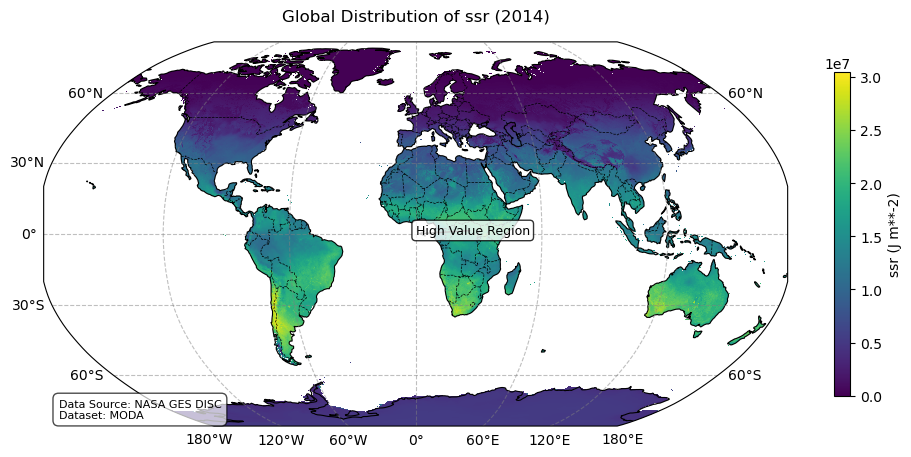

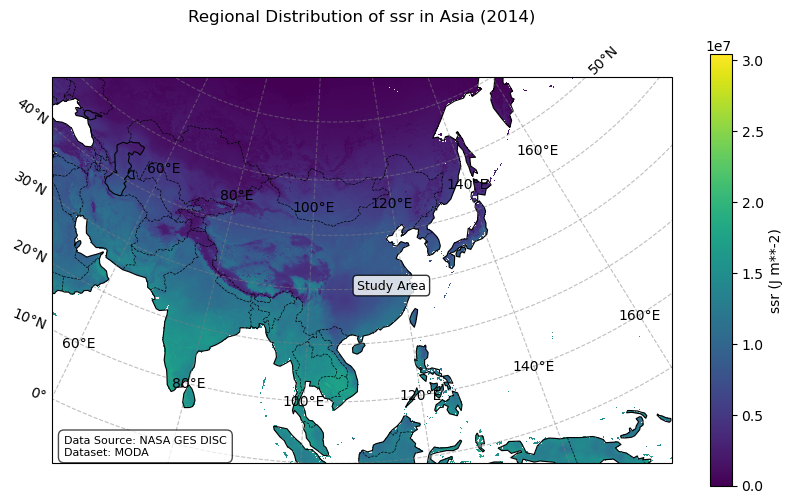

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
#数据读取与预处理 
file_path = r"C:\Users\Morchaim&Hwachi\data_stream-moda.nc"
ds = xr.open_dataset(file_path)
var_name = "ssr"  
time_dim = "valid_time" 
lat_dim = "latitude"     
lon_dim = "longitude"    

# 选取一个时间切片（第一个时间点）
data = ds[var_name].isel({time_dim: 0})  
if data[lon_dim].max() > 180:
    data = data.assign_coords({lon_dim: (data[lon_dim] + 180) % 360 - 180})
    data = data.sortby(lon_dim)

def plot_map(data, ax, proj, extent, title, is_global=True):
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
        add_colorbar=False,
        extend="both"
    )
    
# 添加地理特征
    ax.add_feature(cfeature.LAND, color="lightgray", alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.5)
    
# 设置范围
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.8,
        color="gray",
        alpha=0.5,
        linestyle="--"
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60) if is_global else np.arange(60, 161, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 30) if is_global else np.arange(0, 61, 10))
    
    ax.set_title(title, fontsize=12, pad=15)
    
    cbar = plt.colorbar(im, ax=ax, shrink=0.7, pad=0.05)
    cbar.set_label(f"{var_name} ({ds[var_name].units})" if hasattr(ds[var_name], 'units') else var_name, fontsize=10)
    
    annotate_text = "High Value Region" if is_global else "Study Area"
    annotate_lon = 0 if is_global else 110
    annotate_lat = 0 if is_global else 30
    ax.annotate(
        annotate_text,
        xy=(annotate_lon, annotate_lat),
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        fontsize=9,
        bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.3"),
        arrowprops=dict(arrowstyle="->", color="black")
    )
    
    text_box = "Data Source: NASA GES DISC\nDataset: MODA"
    ax.text(
        0.02, 0.02,
        text_box,
        transform=ax.transAxes,
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.7, boxstyle="round,pad=0.5")
    )
    
    return ax


# 2.1 全球地图 
proj_global = ccrs.Robinson(central_longitude=0)
extent_global = [-180, 180, -90, 90]
title_global = f"Global Distribution of {var_name} (2014)"

fig1, ax1 = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj_global})
ax1 = plot_map(data, ax1, proj_global, extent_global, title_global, is_global=True)
plt.savefig("global_map.png", dpi=300, bbox_inches="tight")


# 2.2 区域地图 
proj_regional = ccrs.LambertConformal(central_longitude=105, central_latitude=35, standard_parallels=(25, 45))
extent_regional = [60, 160, 0, 60]  # 亚洲区域
title_regional = f"Regional Distribution of {var_name} in Asia (2014)"

fig2, ax2 = plt.subplots(figsize=(10, 8), subplot_kw={"projection": proj_regional})
ax2 = plot_map(data, ax2, proj_regional, extent_regional, title_regional, is_global=False)
plt.savefig("regional_map.png", dpi=300, bbox_inches="tight")

plt.show()